<a name='1-1'></a>
## 1.1 Import Packages

In [382]:
import os
import numpy as np
import glob as gb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import cv2
import random


import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from keras.regularizers import l2
from keras import Sequential

sns.set()
%matplotlib inline

In [494]:
train_directory = './dataset/train'
test_directory = './dataset/test'
val_directory = './dataset/val'

In [525]:
HYPERPARAM = {
    "IMG_SIZE": (224,224),
    "BATCH_SIZE": 4,
    "EPOCHS": 10,
    "LEARNING_RATE": 0.001
}

In [526]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen= image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen= image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    fill_mode='nearest')

<a name='1-3'></a>

## 1.2 Create the Dataset and Split it into Training and Validation Sets

In [527]:
train_dataset = train_datagen.flow_from_directory(train_directory,
                                             batch_size=HYPERPARAM['BATCH_SIZE'],
                                             target_size=HYPERPARAM['IMG_SIZE'],
                                             class_mode = 'binary')
val_dataset = val_datagen.flow_from_directory(val_directory,
                                             shuffle=True,
                                             batch_size=HYPERPARAM['BATCH_SIZE'],
                                             target_size=HYPERPARAM['IMG_SIZE'],
                                             class_mode = 'binary')
test_dataset = test_datagen.flow_from_directory(test_directory,
                                             shuffle=True,
                                             batch_size=HYPERPARAM['BATCH_SIZE'],
                                             target_size=HYPERPARAM['IMG_SIZE'],
                                             class_mode = 'binary')

Found 7570 images belonging to 2 classes.
Found 946 images belonging to 2 classes.
Found 947 images belonging to 2 classes.


<a name='2-1'></a>
## 2.1 Check Labels of Images

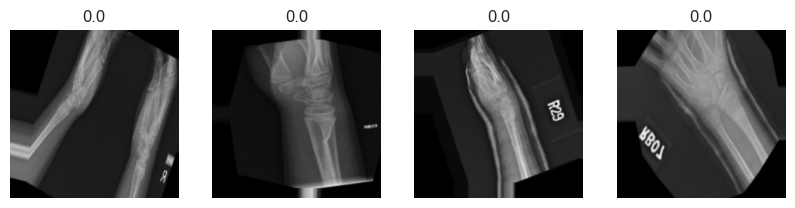

In [528]:
images, labels = next(train_dataset)

# Plot the first four images and their labels
fig, axs = plt.subplots(1, 4, figsize=(10, 10))
for i in range(4):
    axs[i].imshow(images[i])
    axs[i].axis('off')
    axs[i].set_title('{}'.format(labels[i]))
    
plt.show()


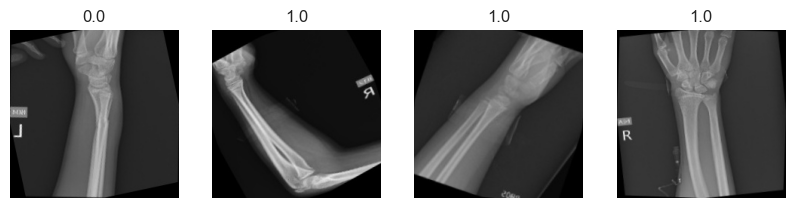

In [529]:
images, labels = next(val_dataset)

# Plot the first four images and their labels
fig, axs = plt.subplots(1, 4, figsize=(10, 10))
for i in range(4):
    axs[i].imshow(images[i])
    axs[i].axis('off')
    axs[i].set_title('{}'.format(labels[i]))
    
plt.show()

In [530]:
#Take preprocessing function from module inception_v3 
preprocess_input = tf.keras.applications.inception_v3.preprocess_input 

In [531]:
input_shape = HYPERPARAM['IMG_SIZE'] + (3,)
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet') 

for layer in base_model.layers:
    layer.trainable=False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.2))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.2))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_52  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_94 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_4454 (B  (None, 512)              2048      
 atchNormalization)                                              
                                                                 
 gaussian_noise_54 (Gaussian  (None, 512)              0         
 Noise)                                                          
                                                     

<a name='3-1'></a>
## 3.1 Building Final Edition Model

In [532]:
loss_function=tf.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=HYPERPARAM['LEARNING_RATE'])

metrics=['accuracy']
model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)


<a name='3-2'></a>
## 3.2 Train Model on our Data

In [541]:
lrp=ReduceLROnPlateau(monitor="val_loss", factor=0.01, patience=2)
checkpoint_filepath = 'best_model.h5'
# Define early stopping and checkpoint callbacks
# early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose = 1)

try:
    model = tf.keras.models.load_model(checkpoint_filepath)
    print("loaded model from filepath")
except:
    print("Checkpoint not found")

# Train the model with callbacks
history = model.fit(train_dataset,
                    epochs=HYPERPARAM['EPOCHS'],
                    validation_data=val_dataset,
                    steps_per_epoch= 50,
                    callbacks=[checkpoint])

loaded model from filepath
Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.6750
Epoch 1: val_accuracy improved from -inf to 0.72727, saving model to best_model.h5
50/50 [==============================] - 26s 513ms/step - loss: 0.6906 - accuracy: 0.6750 - val_loss: 0.5893 - val_accuracy: 0.7273
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.6600
Epoch 2: val_accuracy did not improve from 0.72727
50/50 [==============================] - 24s 488ms/step - loss: 0.6681 - accuracy: 0.6600 - val_loss: 0.5531 - val_accuracy: 0.7220
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.6111
Epoch 3: val_accuracy improved from 0.72727 to 0.74736, saving model to best_model.h5
50/50 [==============================] - 24s 491ms/step - loss: 0.7427 - accuracy: 0.6111 - val_loss: 0.5204 - val_accuracy: 0.7474
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 0.7533 

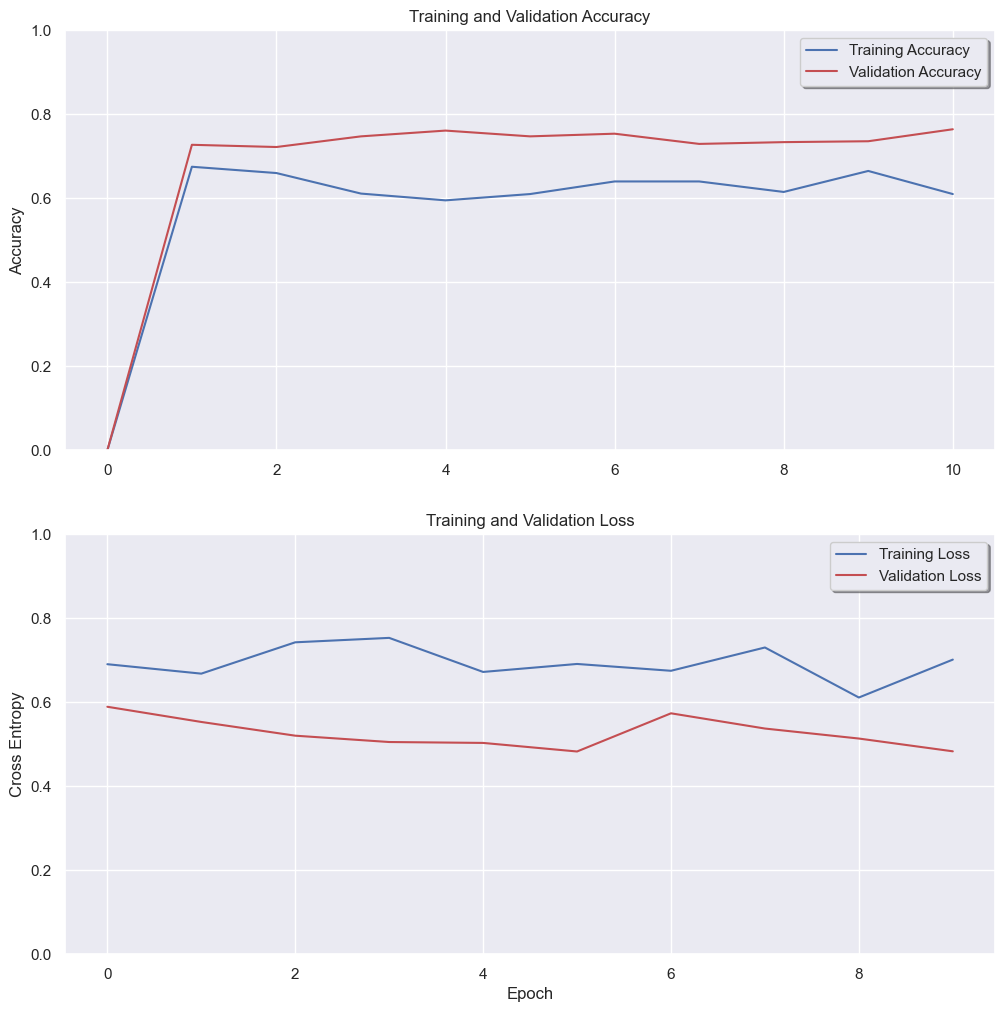

In [542]:
sns.set()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot Training Accuracy
ax1.plot([0.] + history.history['accuracy'], color='b', label='Training Accuracy')
ax1.plot([0.] + history.history['val_accuracy'], color='r', label='Validation Accuracy')
ax1.set_ylim([0, 1])
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy')

# Plot Training Loss
ax2.plot(history.history['loss'], color='b', label='Training Loss')
ax2.plot(history.history['val_loss'], color='r', label='Validation Loss')
ax2.set_ylim([0, 1])
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('Cross Entropy')
ax2.set_xlabel('Epoch')
ax2.set_title('Training and Validation Loss')

plt.show()

In [546]:
total_epochs =  HYPERPARAM['EPOCHS'] + 5
#Train model on 10 more epochs
history_More = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         steps_per_epoch= 50,
                         validation_data=val_dataset)

Epoch 10/15
50/50 [==============================] - 25s 509ms/step - loss: 0.6256 - accuracy: 0.6550 - val_loss: 0.4904 - val_accuracy: 0.7653
Epoch 11/15
50/50 [==============================] - 27s 550ms/step - loss: 0.6335 - accuracy: 0.6900 - val_loss: 0.4637 - val_accuracy: 0.7674
Epoch 12/15
50/50 [==============================] - 28s 569ms/step - loss: 0.6871 - accuracy: 0.6500 - val_loss: 0.4984 - val_accuracy: 0.7653
Epoch 13/15
50/50 [==============================] - 28s 575ms/step - loss: 0.6518 - accuracy: 0.6600 - val_loss: 0.4662 - val_accuracy: 0.7748
Epoch 14/15
50/50 [==============================] - 24s 493ms/step - loss: 0.6498 - accuracy: 0.6550 - val_loss: 0.4584 - val_accuracy: 0.7717
Epoch 15/15
50/50 [==============================] - 24s 493ms/step - loss: 0.6589 - accuracy: 0.6100 - val_loss: 0.4545 - val_accuracy: 0.7822


<a name='4'></a>
# 4 - Evaluation Model

In [548]:
#add more epochs to plot
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

acc += history_More.history['accuracy']
val_acc += history_More.history['val_accuracy']

loss += history_More.history['loss']
val_loss += history_More.history['val_loss']

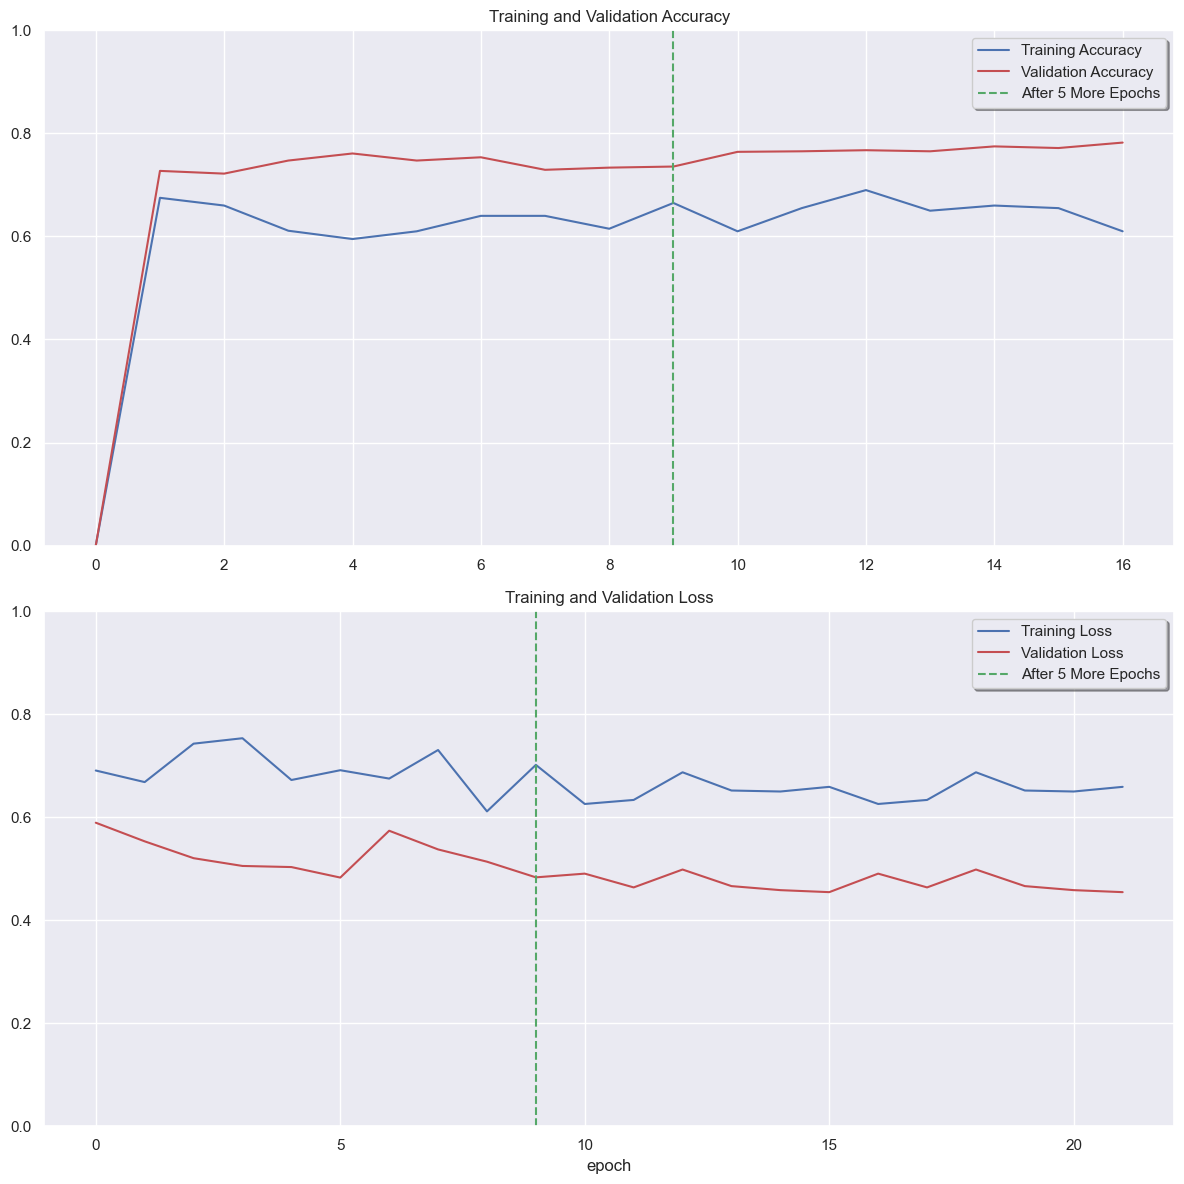

In [549]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(acc, color='b',  label='Training Accuracy')
ax1.plot(val_acc, color='r',  label='Validation Accuracy')
ax1.set_ylim([0, 1])
ax1.plot([HYPERPARAM['EPOCHS']-1,HYPERPARAM['EPOCHS']-1],
          plt.ylim(), 'g--', label='After 5 More Epochs')
ax1.legend(loc='best', shadow=True)
ax1.set_title('Training and Validation Accuracy')

ax2.plot(loss, color='b',  label='Training Loss')
ax2.plot(val_loss, color='r', label='Validation Loss')
ax2.set_ylim([0, 1.0])
ax2.plot([HYPERPARAM['EPOCHS']-1,HYPERPARAM['EPOCHS']-1],
         plt.ylim(), 'g--', label='After 5 More Epochs')
ax2.legend(loc='best', shadow=True)
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('epoch')
plt.tight_layout()
plt.show()

In [550]:
model.save('v1_bone_fracture_model.h5')

In [551]:
model.save_weights('v1_bone_fracture_weights.h5')

In [553]:
model.load_weights('v1_bone_fracture_model.h5')
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

237/237 [==============================] - 20s 86ms/step - loss: 0.4477 - accuracy: 0.8057
Test Loss: 0.4477443993091583
Test Accuracy: 0.8057022094726562
